### Домашнее задание 3

В данном задании вам нужно будет провести анализ данных проведенного A/B-теста.

Данные будут предоставлены в формате csv. Они будут содержать также часть пред экспериментального этапа.

**Описание эксперимента**  
Есть мобильное приложение. В этом приложении у пользователей есть возможность покупать игровые предметы за реальные деньги. Чтобы стимулировать пользователей их покупать, приложение периодически предлагает пользователям товары - появляется окошко с рекомендацией купить товар. Отдел машинного обучения предложил улучшение для текущего алгоритма выбора рекомендации. Для проверки улучшений алгоритма был проведен A/B тест. Лог его проведения предоставлен в прикрепленном файле. 

**Метрика**  
Средний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

**Важная информация**  
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
Вам сказали, что его длительность должна составить 1 месяц.
Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

**Описание данных**  
- id_product -  идентификатор продукта, который был рекомендован
- is_pay - купил ли пользователь товар
- sum_payment - размер платежа (0, если не купил)
- city - город, в котором находится пользователь
- id_user - пользователь
- timestamp - timestamp события
- date - дата события

**Задачи, которые необходимо решить**
1. Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных.
3. Построить методику расчета целевой метрики.
4. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. 
5. Рассчитать метрики из п2 по дням и построить их графики.
6. Принять решение о результате теста - обосновать.

**Дополнительно**  
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import scipy.stats as sps

#### Дисклеймер

Чтобы оценить длительность теста, нам сперва нужно почистить данные и построить методику расчета целевой метрики. Поэтому порядок работы над проектом будет изменен.

#### 1. Метод расчета целевой метрики

**Дисклеймер 2**

Трактовать определение метрики можно по-разному. После комментария в дискорде, а именно:

*- В описании задачи сказано, что тут данные только за платежи связанные с показом рекомендации, все время а течении недели пользователь их получает, поэтому метрика получается только от его взаимодействия с рекомендациями*  

Можно дать более точное определение ключевой метрики:  
**Ключевая метрика** - сколько потратил пользователь в течение одной недели, после того как мы показали ему **любую** рекомендацию. Все, что происходит с пользователем после этой недели нас не волнует.

In [326]:
data = pd.read_csv("data.gzip", compression='gzip')
data.head()

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
0,1680330573,user_9903,27,NaN,Санкт-Петербург,4.0,1,2023-04-01
1,1680332652,user_6732,0,NaN,Рязань,1.0,0,2023-04-01
2,1680378039,user_4199,0,NaN,Москва,3.0,0,2023-04-01
3,1680337580,user_3606,12,NaN,Санкт-Петербург,7.0,1,2023-04-01
4,1680334389,user_9519,0,NaN,Санкт-Петербург,14.0,0,2023-04-01


In [25]:
data.sort_values(by=['date'], ascending=False)

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
56404,1685528033,user_6637,0,B,Москва,19.0,0,2023-05-31
53381,1685563157,user_6842,0,A,Рязань,20.0,0,2023-05-31
53375,1685562032,user_6607,0,B,Санкт-Петербург,4.0,0,2023-05-31
53376,1685564129,user_6607,0,B,Санкт-Петербург,8.0,0,2023-05-31
53377,1685530496,user_6846,0,A,Рязань,17.0,0,2023-05-31
...,...,...,...,...,...,...,...,...
12,1680322044,user_773,0,NaN,Москва,20.0,0,2023-04-01
13,1680373378,user_760,0,NaN,Санкт-Петербург,1.0,0,2023-04-01
14,1680309617,user_773,0,NaN,Москва,6.0,0,2023-04-01
15,1680341627,user_104,0,NaN,Ярославь,1.0,0,2023-04-01


In [498]:
def get_metric_in_date(data: pd.DataFrame, date_start: str, date_end: str) -> pd.DataFrame:
    filtred_data = data[(date_start <= data.date) & (data.date <= date_end)]
    
    unique_users_at_start = filtred_data.id_user.unique().shape[0]
    first_payment = pd.DataFrame(filtred_data.groupby('id_user')['date'].min()).reset_index().rename(columns={'date': 'first_payment_date'})
    merged_data = filtred_data.merge(first_payment, on='id_user')
    
    merged_data['date'] = pd.to_datetime(merged_data['date'])
    merged_data['first_payment_date'] = pd.to_datetime(merged_data['first_payment_date'])
    
    filtred_data = merged_data[merged_data['date'] <= (merged_data['first_payment_date'] + pd.to_timedelta(7, unit='d'))]
    
    metric_data = filtred_data.groupby(by=['id_user', 'group']).sum().reset_index()
    metric_data = metric_data[['id_user', 'sum_payment', 'group']]
    
    unique_users_at_end = metric_data.id_user.unique().shape[0]
    
    assert unique_users_at_end == unique_users_at_start

    return metric_data

#### 2. Исследование метрики по окончанию эксперимента

In [417]:
metric_data = get_metric_in_date(data, '2023-05-01', '2023-06-01')
metric_data.sort_values(by='sum_payment')

/var/folders/qg/qf0y_9l119xdw7z_0pj_zsrc0000gn/T/ipykernel_88169/3954307869.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metric_data = filtred_data.groupby(by=['id_user', 'group']).sum().reset_index()


,id_user,sum_payment,group
0,user_0,0,A
6803,user_5320,0,A
6802,user_532,0,A
6799,user_5317,0,B
6798,user_5316,0,A
...,...,...,...
3657,user_249,178,B
9295,user_7564,193,A
9384,user_7644,203,A
2220,user_11996,1000,A


In [455]:
metric_A = metric_data[metric_data['group'] == 'A'].sum_payment.mean()
metric_B = metric_data[metric_data['group'] == 'B'].sum_payment.mean()
metrics_diff_percent = round((metric_B - metric_A) / metric_A * 100, 3)
effect = metric_B - metric_A
print(f'Mean payment sum by user in group A: {round(metric_A,3)}\nMean payment sum by user in group B: {metric_B}')
print(f'Effect: {round(effect,3)}')
print(f'Metric changed on {metrics_diff_percent}%')

Mean payment sum by user in group A: 12.63
Mean payment sum by user in group B: 13.471
Effect: 0.841
Metric changed on 6.662%


In [446]:
group_A_distr = metric_data[metric_data['group'] == 'A'].sum_payment.values
group_B_distr = metric_data[metric_data['group'] == 'B'].sum_payment.values

#### Доказательство применимости теста Стьюдента

1. Выборочные средние распределены нормально
2. Равенство дисперсий

##### Проверяем выборочные средние

In [464]:
def get_bootstrap_sample_indices(sample_size: int, n_samples: int) -> np.ndarray:
    return np.random.randint(0, sample_size, (n_samples, sample_size))

def get_bootstrap_samples(X: np.ndarray, n_samples: int) -> np.ndarray:
    return X[get_bootstrap_sample_indices(len(X), n_samples)]

In [488]:
group_A_samples = get_bootstrap_samples(group_A_distr, 10000)
group_B_samples = get_bootstrap_samples(group_B_distr, 10000)

metrics_A_mean_ar = [np.mean(group_A_samples[i]) for i in range(len(group_A_samples))]
metrics_B_mean_ar = [np.mean(group_A_samples[i]) for i in range(len(group_A_samples))]

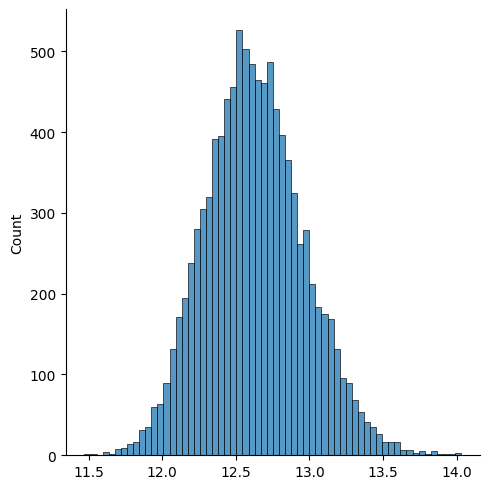

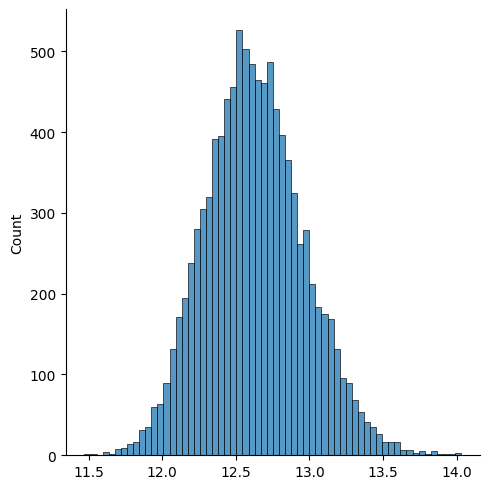

In [493]:
sns.displot(metrics_A_mean_ar)
sns.displot(metrics_B_mean_ar)

**Вывод:**  
Выборочные средние распределены нормально.

##### Проверяем дисперсии

In [499]:
group_A_variation = sps.variation(group_A_distr)
print(group_A_variation)

2.045657070709622


In [501]:
group_B_variation = sps.variation(group_B_distr)
print(group_B_variation)

1.4246564782820632


**Вывод:**
Нет большой разницы в дисперсии

Можно использовать тест Стьюдента для оценки p-value

#### Считаем p-value через тест Стьюдента

In [459]:
t_test = sps.ttest_ind(group_B_distr, group_A_distr, alternative='two-sided')
pvalue = t_test.pvalue

##### Стат.значим ли результат

In [461]:
alpha = 0.05

In [463]:
if pvalue < alpha:
    print('Победа! Результат стат.значим')
else:
    print('Не-а, результат не стат.значим')

Победа! Результат стат.значим


Это так же означает, что время для эксперимента достаточное. Возможно, можно сделать и меньше.

#### 3. Оценка длительности теста

In [1]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

In [502]:
calc_duration = duration(k=1, 
                         delta_effect=effect, 
                         sigma_1=math.sqrt(group_A_variation),
                         sigma_2=math.sqrt(group_B_variation))

In [503]:
calc_duration

76.96091002718161

#### 4. Графики по дням

Не очень понял, если честно, что требуется нарисовать.

#### 5. Принятие решения "Катим в прод"

1. Данных насобирали в достаточном объеме, чтобы ощутить разницу в 5% и более
2. Метрика поднялась на 6%
3. Стат.значимость подтверждена

**Можно закатывать фичу**

P.S.
Знаю, сделал не все пункты (сделал самые интересные).